In [6]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import plotly as px
from piq import SSIMLoss, MultiScaleSSIMLoss, ssim, multi_scale_ssim
import random
from torch.utils.data import DataLoader, Dataset, random_split

# Denoise image

### В чем заключается задача ? 


Задача "удаление шума" заключается в том, чтобы удалить шум из изображения или сигнала, сохраняя при этом максимально возможное количество информации. Шум может быть вызван различными причинами, например, низким качеством записи или передачи данных, воздействием электромагнитных помех, механическими вибрациями и т.д.

Одной из основных проблем в задаче "Denoise" является отсутствие незашумленной версии изображения или сигнала, которую можно было бы использовать для сравнения. Это усложняет процесс удаления шума, так как необходимо определить, какая информация в изображении или сигнале является шумом, а какая - сигналом.

В таких случаях, обычно используются статистические методы, которые позволяют оценить свойства шума на основе известных данных о среде, в которой было сделано изображение или записан сигнал. Также могут быть использованы методы машинного обучения, в которых модель обучается на шумных данных и применяется для удаления шума на новых данных.

### Какие на сегодня есть популярные дата сеты ?

<b>CBSD68</b> -- Этот эталонный набор данных широко используется для измерения производительности алгоритмов шумоподавления изображений, однако мне не удалось его найти. Он включает в себя исходные файлы .jpg, преобразованные в .png без потерь, и зашумленные с помощью Additive White Gaussian Noise разных уровней. 

ссылка на датасет: https://github.com/smartboy110/denoising-datasets.git

<b> Smartphone Image Denoising Dataset (SIDD) </b>-- Новый датасет для смартфонов.

Набор данных содержит 160 пар шумных/наземных изображений, сделанных следующими смартфонами при разном освещении:

GP: Google Pixel
IP: iPhone 7
S6: Samsung Galaxy S6 Edge
N6: Motorola Nexus 6
G4: LG G4

Из-за небольшой апертуры и размера сенсора изображения со смартфона обычно имеют больше шума, чем их аналоги с зеркальных камер. Учитывая тот факт, что шумоподавление изображений является активной областью исследований, авторы разработали набор данных изображений шумоподавления, представляющий реальные зашумленные изображения с камер смартфонов с высококачественной достоверностью. Набор данных использовался в NTIRE 2020 Real Image Denoising Challenge совместно с CVPR 2020 .

ссылка на датасет: https://www.kaggle.com/datasets/rajat95gupta/smartphone-image-denoising-dataset


Другие наборы данных: https://figshare.com/articles/dataset/BSD100_Set5_Set14_Urban100/21586188


### Пример Изображений из набора CBSD68

<div>
    <img src="./data/denoise/BSD68/noise50/test001.png", style="float:left"> 
    <img src="./data/denoise/BSD68/original/test001.png"> 
</div>


### Пример Изображений из набора SIDD

<div>
    <img src="./DATASET/GT_SRGB_010.png", style="float:left"> 
    <img src="./DATASET/GT_SRGB_010_.png"> 
</div>


### Метрики 

Peak Signal to Noise Ratio (PSNR) -- метрика, которая измеряет отношение максимального значения сигнала к квадрату среднеквадратической ошибки (MSE) между зашумленным и очищенным изображениями. Чем выше значение PSNR, тем более похожи очищенное и незашумленное изображения.



$$PSNR = 10\log_{10}\frac{MAX_I^2}{MSE}$$

где $MAX_I$ - это максимальное значение интенсивности пикселя (в нашем случае, $MAX_I=255$, если изображения представлены в формате 8-битных значений), а $MSE$ - это среднеквадратическая ошибка между исходным (незашумленным) изображением $I$ и зашумленным изображением $\hat{I}$:



SSIM (Structural Similarity Index) - это метрика качества изображений, которая учитывает не только ошибки яркости, но и структурные изменения в изображении. Его формула определяется как:

$$ \text{SSIM}(x,y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}, $$

где $x$ и $y$ - это два изображения для сравнения, $\mu_x$ и $\mu_y$ - это средние значения пикселей в $x$ и $y$ соответственно, $\sigma_x$ и $\sigma_y$ - это стандартные отклонения пикселей в $x$ и $y$, $\sigma_{xy}$ - это ковариация пикселей в $x$ и $y$, а $c_1$ и $c_2$ - это константы для стабилизации деления на ноль. Значения $c_1$ и $c_2$ обычно устанавливаются на $0.01$.

Формула может быть преобразована для вычисления значения SSIM между двумя локальными областями $x$ и $y$, как:

$$ \text{SSIM}(x,y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}. $$

Здесь $\mu_x$, $\mu_y$, $\sigma_x$, $\sigma_y$, и $\sigma_{xy}$ вычисляются для каждой локальной области.




In [7]:
def plot_images(images, titles=None, rows=1, figsize=(5, 5)):
    fig, axs = plt.subplots(rows, len(images)//rows, figsize=figsize)
    axs = axs.ravel()
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray')
        axs[i].axis('off')
        if titles is not None:
            axs[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

In [8]:
def psnr(target, ref, max_value=255.0):
    # Если входные данные - это тензоры PyTorch, преобразуем их в массивы NumPy
    if isinstance(target, torch.Tensor):
        target = target.cpu().detach().numpy()
    if isinstance(ref, torch.Tensor):
        ref = ref.cpu().detach().numpy()

    # Вычисляем среднеквадратическую ошибку
    mse = np.mean((target - ref) ** 2)

    # Вычисляем PSNR
    if mse == 0:
        return float("inf")
    else:
        return 10 * np.log10((max_value ** 2) / mse)

PSNR: 21.58
SSIM: 0.36
MS-SSIM: 0.76


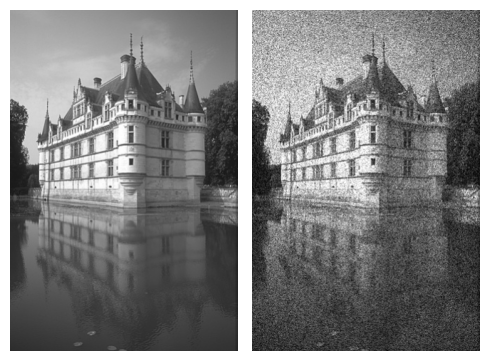

In [9]:
# Загружаем зашумленное и незашумленное изображения
noisy_img = cv2.imread("./data/denoise/BSD68/noise50/test003.png")
clean_img = cv2.imread("./data/denoise/BSD68/original/test003.png")

# Преобразуем изображения в тензоры PyTorch
noisy_img_tensor = torch.from_numpy(noisy_img.transpose((2, 0, 1))).float().unsqueeze(0)
clean_img_tensor = torch.from_numpy(clean_img.transpose((2, 0, 1))).float().unsqueeze(0)

# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)

# Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)

# Вычисляем MS-SSIM
ms_ssim_value = multi_scale_ssim(noisy_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}")
print(f"SSIM: {ssim_value:.2f}")
print(f"MS-SSIM: {ms_ssim_value:.2f}")


plot_images([clean_img, noisy_img])

PSNR: inf
SSIM: 1.00
MS-SSIM: 1.00


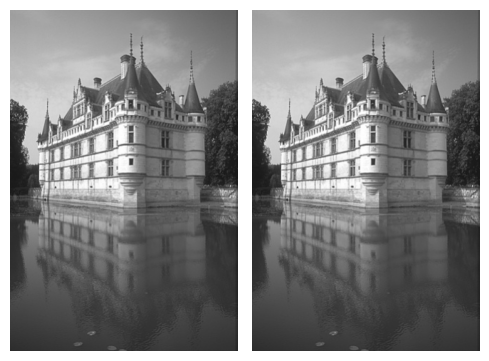

In [10]:
# Вычисляем PSNR
psnr_value = psnr(clean_img_tensor, clean_img_tensor)

# Вычисляем SSIM
ssim_value =  ssim(clean_img_tensor, clean_img_tensor, data_range=255)

# Вычисляем MS-SSIM
ms_ssim_value = multi_scale_ssim(clean_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}")
print(f"SSIM: {ssim_value:.2f}")
print(f"MS-SSIM: {ms_ssim_value:.2f}")

plot_images([clean_img, clean_img])

PSNR: 27.11
SSIM: 0.99
MS-SSIM: 1.00


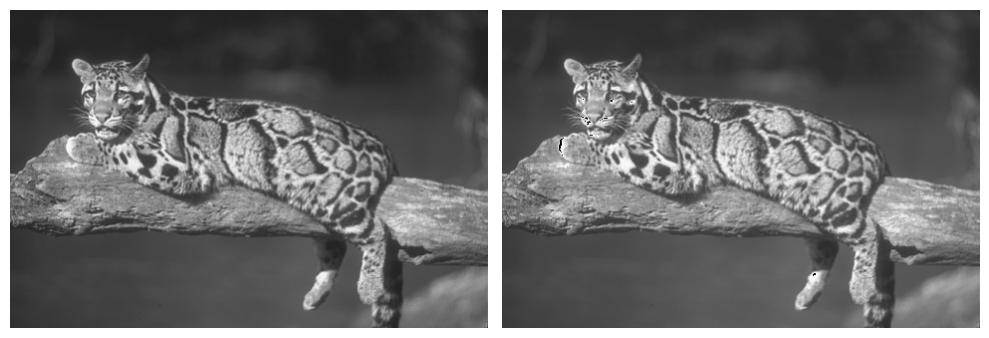

In [13]:
# Загружаем зашумленное и незашумленное изображения
clean_img = cv2.imread("./data/denoise/BSD68/original/test025.png")
noisy_img = clean_img + 10 

# Преобразуем изображения в тензоры PyTorch
noisy_img_tensor = torch.from_numpy(noisy_img.transpose((2, 0, 1))).float().unsqueeze(0)
clean_img_tensor = torch.from_numpy(clean_img.transpose((2, 0, 1))).float().unsqueeze(0)

# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)

# Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)

# Вычисляем MS-SSIM
ms_ssim_value = multi_scale_ssim(noisy_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}")
print(f"SSIM: {ssim_value:.2f}")
print(f"MS-SSIM: {ms_ssim_value:.2f}")

plot_images([clean_img, noisy_img], figsize=(10, 10))

# Методы устранения шума

Медианный фильтр - это простой и эффективный метод устранения шума. Формула для медианного фильтра в обработке изображений может быть записана как:

$$ g(x,y) = med{f(x,y)}$$

где $f$ - это исходное изображение, $g$ - это отфильтрованное изображение, $\text{med}$ - это оператор медианы, а $(i,j)$ - это смещение от текущей позиции $(x,y)$.

In [14]:
def median_filter(  img: np.ndarray, filter_size: int) -> np.ndarray:
    
    padded_image = np.pad(img, [(filter_size//2, filter_size//2), (filter_size//2, filter_size//2)], mode='constant')
    filtered_image = np.zeros_like(img)
    
    x, y = img.shape
    
    for i in range(x):
        for j in range(y):
            filtered_image[i, j] = np.median(padded_image[i:i+filter_size, j:j+filter_size])
    
    return filtered_image

PSNR: 21.58, 24.82
SSIM: 0.36, 0.69


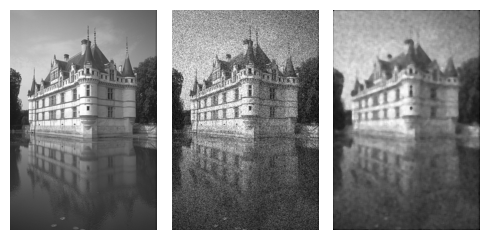

In [15]:
# Загружаем зашумленное и незашумленное изображения
noisy_img  = cv2.imread("./data/denoise/BSD68/noise50/test003.png")
clean_img  = cv2.imread("./data/denoise/BSD68/original/test003.png")
median_img = median_filter(noisy_img[..., 0], 7) 
# Преобразуем изображения в тензоры PyTorch
noisy_img_tensor  = torch.from_numpy(noisy_img.transpose((2, 0, 1))).float().unsqueeze(0)
clean_img_tensor  = torch.from_numpy(clean_img.transpose((2, 0, 1))).float().unsqueeze(0)
median_img_tensor = torch.from_numpy(np.dstack([median_img,
                                                median_img,
                                                median_img]).transpose((2, 0, 1))).float().unsqueeze(0)
# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)
psnr_value_median = psnr(median_img_tensor, clean_img_tensor)
# Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)
ssim_value_median = ssim(median_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}, {psnr_value_median:.2f}")
print(f"SSIM: {ssim_value:.2f}, {ssim_value_median:.2f}")

plot_images([clean_img, noisy_img, median_img])

PSNR: 21.58, 23.53
SSIM: 0.36, 0.69


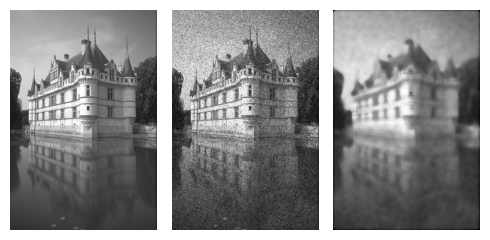

In [16]:
median_img = median_filter(noisy_img[..., 0], 11) 
# Преобразуем изображения в тензоры PyTorch
median_img_tensor = torch.from_numpy(np.dstack([median_img,
                                                median_img,
                                                median_img]).transpose((2, 0, 1))).float().unsqueeze(0)
# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)
psnr_value_median = psnr(median_img_tensor, clean_img_tensor)
# Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)
ssim_value_median = ssim(median_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}, {psnr_value_median:.2f}")
print(f"SSIM: {ssim_value:.2f}, {ssim_value_median:.2f}")

plot_images([clean_img, noisy_img, median_img])

PSNR: 21.58, 21.66
SSIM: 0.36, 0.65


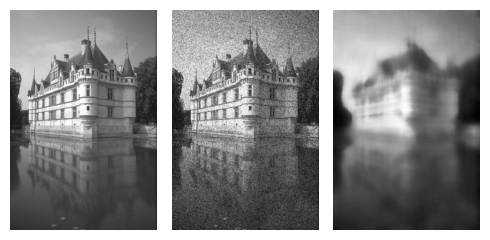

In [17]:
median_img = cv2.medianBlur(noisy_img[..., 0], 23) 
# Преобразуем изображения в тензоры PyTorch
median_img_tensor = torch.from_numpy(np.dstack([median_img,
                                                median_img,
                                                median_img]).transpose((2, 0, 1))).float().unsqueeze(0)
# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)
psnr_value_median = psnr(median_img_tensor, clean_img_tensor)
# Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)
ssim_value_median = ssim(median_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}, {psnr_value_median:.2f}")
print(f"SSIM: {ssim_value:.2f}, {ssim_value_median:.2f}")

plot_images([clean_img, noisy_img, median_img])

<b>Билитериальный фильтр</b> — это нелинейный фильтр сглаживания изображений с сохранением границ и шумоподавлением. Он заменяет интенсивность каждого пикселя средневзвешенным значением интенсивности ближайших пикселей. Этот вес может быть основан на распределении Гаусса. Важно отметить, что веса зависят не только от евклидова расстояния между пикселями, но и от радиометрических различий (например, различий по дальности, таких как интенсивность цвета, расстояние по глубине и т. д.). Это позволяет сохранить острые края.


$$BF[I]_p = \frac{1}{W_p} G_{\sigma_s}(|| p - q ||) G_{\sigma_r}(|| I_p - I_q ||) Iq $$

Где:


$$W_p = \sum\limits_{q \in S} G_{\sigma_s}(|| p - q ||) G_{\sigma_r}(|| I_p - I_q ||)$$

$BF[I]_p$: Отфильтрованное изображение.

$p$: Положение выходного пиксел

$q$: Положение пикселя по соседству с выходным пикселем.

$I_p$: исходный цвет выходного пикселя

$I_q$: Цвет пикселя в окрестности выходного пикселя.

$S$: окрестность выходного пикселя

$G_{\sigma_s}$: фильтр Гаусса со стандартным отклонением $\sigma_s$ для взвешивания пикселей в зависимости от расстояния

$G_{\sigma_r}$:фильтр Гаусса со стандартным отклонением $\sigma_r$ для взвешивания пикселей в зависимости от цветового расстояния

In [18]:
def vec_gaussian(img: np.ndarray, variance: float) -> np.ndarray:
    # Для применения функции Гаусса для каждого элемента в матрице.
    sigma = np.sqrt(variance)
    const = 1 / (sigma * np.sqrt(2 * np.pi))
    
    return const * np.exp(-((img / sigma) ** 2) * 0.5)


def get_slice(img: np.ndarray, x: int, y: int, kernel_size: int) -> np.ndarray:
    half = kernel_size // 2
    return img[x - half : x + half + 1, y - half : y + half + 1]


def get_gauss_kernel(kernel_size: int, spatial_variance: float) -> np.ndarray:
    # Создает гауссово ядро заданной размерности
    arr = np.zeros((kernel_size, kernel_size))
    for i in range(0, kernel_size):
        for j in range(0, kernel_size):
            arr[i, j] = np.sqrt(
                np.abs(i - kernel_size // 2) ** 2 + abs(j - kernel_size // 2) ** 2
            )
    return vec_gaussian(arr, spatial_variance)

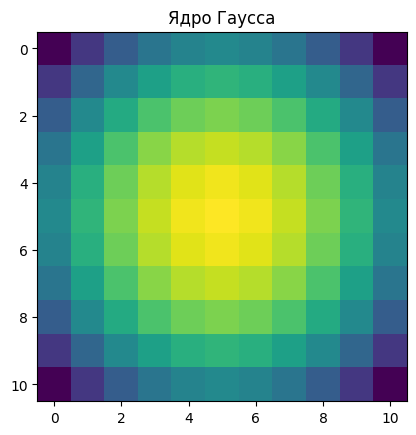

In [19]:
plt.imshow(get_gauss_kernel(11, 100))
plt.title("Ядро Гаусса")
plt.show()

In [20]:
def bilateral_filter(
    img: np.ndarray,
    spatial_variance: float,
    intensity_variance: float,
    kernel_size: int,
) -> np.ndarray:
    
    # Создаем буферное изображение для хронение
    new_img = np.zeros_like(img)
    # Создаем ядро Gauss
    gauss_kernel = get_gauss_kernel(kernel_size, spatial_variance)
    # Получаем шиину и высоту изображения
    x, y = img.shape
    
    for i in range(int(kernel_size // 2), x - int(kernel_size // 2)):
        for j in range(int(kernel_size // 2), y - int(kernel_size // 2)):
            # взяли часть изображения с размером ядра kernel_size
            img_slice = get_slice(img, i, j, kernel_size) 
            # Ip - Iq убираем низкие частоты
            img_I     = img_slice - img_slice[kernel_size // 2, kernel_size // 2]
            # уселение высоких частот (цветовой)
            img_IG    = vec_gaussian(img_I, intensity_variance)
            # получили новые веса (пространство)
#             weights   = gauss_kernel @ img_IG
            weights   = np.real(np.fft.ifft2(np.fft.fft2(gauss_kernel) * np.fft.fft2(img_IG)))
            # свертка старого изображения с новыми весами  
            vals = np.real(np.fft.ifft2(np.fft.fft2(img_slice) * np.fft.fft2(weights)))
#             vals      = img_slice @ weights
            # нормировка
            val       = np.sum(vals) / np.sum(weights)
            # запись значения
            new_img[i, j] = val
            
    return new_img

PSNR: 21.58, 11.12
SSIM: 0.36, 0.50


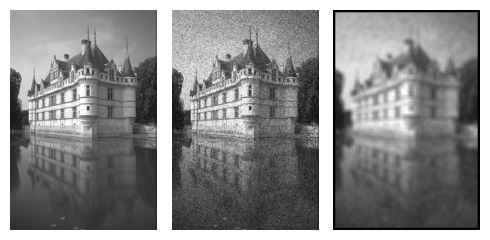

In [21]:
# Загружаем зашумленное и незашумленное изображения
noisy_img     = cv2.imread("./data/denoise/BSD68/noise50/test003.png")
clean_img     = cv2.imread("./data/denoise/BSD68/original/test003.png")
bilateral_img = bilateral_filter(noisy_img[..., 0] / 255.0, spatial_variance=10, intensity_variance=10, kernel_size=11) 
# Преобразуем изображения в тензоры PyTorch
noisy_img_tensor  = torch.from_numpy(noisy_img.transpose((2, 0, 1))).float().unsqueeze(0)
clean_img_tensor  = torch.from_numpy(clean_img.transpose((2, 0, 1))).float().unsqueeze(0)
bilateral_img_tensor = torch.from_numpy(np.dstack([bilateral_img,
                                                bilateral_img,
                                                bilateral_img]).transpose((2, 0, 1))).float().unsqueeze(0)
# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)
psnr_value_bilateral = psnr(bilateral_img_tensor, clean_img_tensor)
# Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)
ssim_value_bilateral = ssim(bilateral_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}, {psnr_value_bilateral:.2f}")
print(f"SSIM: {ssim_value:.2f}, {ssim_value_bilateral:.2f}")

plot_images([clean_img, noisy_img, bilateral_img])

Также данный алгоритм можно использовать из библиотеки opencv 

PSNR: 28.72, 31.56
SSIM: 0.36, 0.74


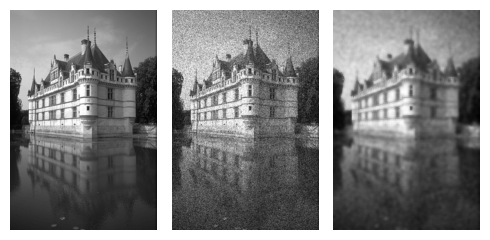

In [22]:
noisy_img     = cv2.imread("./data/denoise/BSD68/noise50/test003.png", 0)
clean_img     = cv2.imread("./data/denoise/BSD68/original/test003.png", 0)

bilateral_img = cv2.bilateralFilter(noisy_img, d=11, sigmaColor=100, sigmaSpace=100)

# Вычисляем PSNR
psnr_value = psnr(noisy_img, clean_img)
psnr_value_bilateral = psnr(bilateral_img, clean_img)
# Вычисляем SSIM
ssim_value =  ssim(torch.tensor(noisy_img).unsqueeze(0).unsqueeze(0), 
                   torch.tensor(clean_img).unsqueeze(0).unsqueeze(0), data_range=255)
ssim_value_bilateral = ssim(torch.tensor(bilateral_img).unsqueeze(0).unsqueeze(0),
                         torch.tensor(clean_img).unsqueeze(0).unsqueeze(0), data_range=255)

print(f"PSNR: {psnr_value:.2f}, {psnr_value_bilateral:.2f}")
print(f"SSIM: {ssim_value:.2f}, {ssim_value_bilateral:.2f}")

plot_images([clean_img, noisy_img, bilateral_img])

<b>BM3D (Block-Matching 3D)</b> - это алгоритм нелинейного нечеткого фильтра для уменьшения шума в изображениях. Он был представлен в 2007 году авторами Костасом Дабовасом (Kostas Dabovas), Александром Фойгельом (Alessandro Foi), Вениамином Катц (Vladimir Katkovnik) и Кари Патриком Кулли (Karen Egiazarian).

Алгоритм BM3D использует метод блочного сопоставления для нахождения групп блоков в изображении, содержащих похожие структуры, и затем применяет 3D-фильтрацию к этим блокам. В отличие от традиционных методов уменьшения шума, которые работают в пространственном или частотном пространстве, BM3D использует блочное сопоставление для нахождения похожих блоков в пространственной и частотной областях. Затем эти блоки агрегируются и фильтруются для уменьшения шума.

BM3D показал высокую эффективность в уменьшении шума в различных типах изображений, включая графические изображения, фотографии и медицинские изображения. Он также имеет ряд модификаций и улучшений, которые позволяют его применять в различных сценариях.

In [24]:
import bm3d

PSNR: 21.58, 32.38
SSIM: 0.36, 0.84


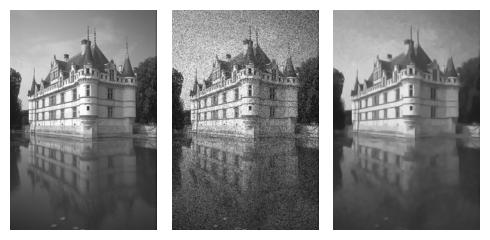

In [26]:
# Загружаем зашумленное и незашумленное изображения
noisy_img = cv2.imread("./data/denoise/BSD68/noise50/test003.png")
clean_img = cv2.imread("./data/denoise/BSD68/original/test003.png")

bm3d_img = bm3d.bm3d(noisy_img, sigma_psd=33, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING).astype(np.uint8)

# Преобразуем изображения в тензоры PyTorch
noisy_img_tensor = torch.from_numpy(noisy_img.transpose((2, 0, 1))).float().unsqueeze(0)
clean_img_tensor = torch.from_numpy(clean_img.transpose((2, 0, 1))).float().unsqueeze(0)
bm3d_img_tensor  = torch.from_numpy(bm3d_img.transpose((2, 0, 1))).float().unsqueeze(0)


# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)
psnr_value_bm3d = psnr(bm3d_img, clean_img)
# # Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)
ssim_value_bm3d = ssim(bm3d_img_tensor, clean_img_tensor, data_range=255)

print(f"PSNR: {psnr_value:.2f}, {psnr_value_bm3d:.2f}")
print(f"SSIM: {ssim_value:.2f}, {ssim_value_bm3d:.2f}")


plot_images([clean_img, noisy_img, bm3d_img])

PSNR: 21.58, 21.66, 31.56, 32.38
SSIM: 0.36, 0.65, 0.74, 0.84


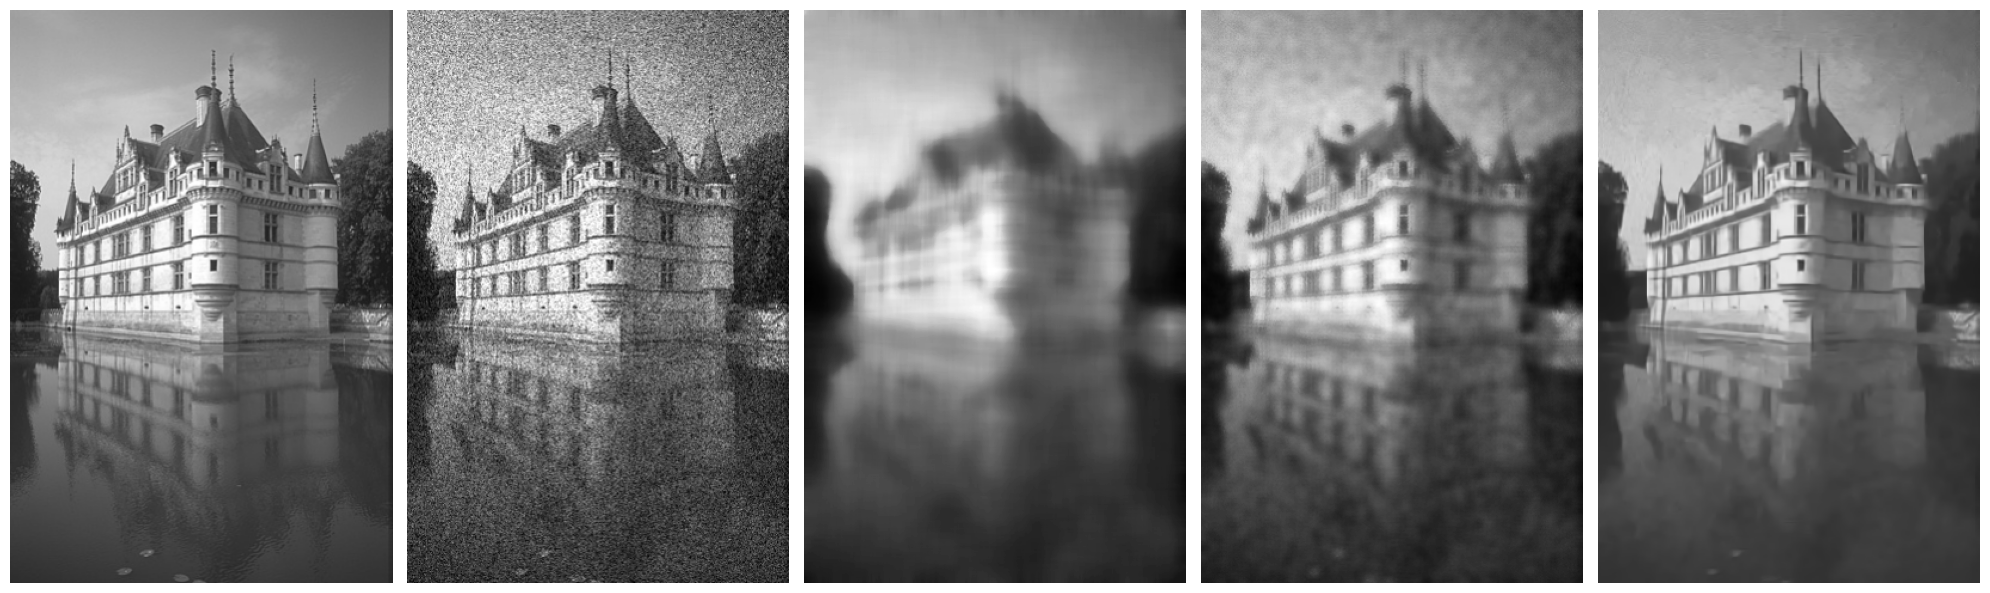

In [27]:
print(f"PSNR: {psnr_value:.2f}, {psnr_value_median:.2f}, {psnr_value_bilateral:.2f}, {psnr_value_bm3d:.2f}")

print(f"SSIM: {ssim_value:.2f}, {ssim_value_median:.2f}, {ssim_value_bilateral:.2f}, {ssim_value_bm3d:.2f}")


plot_images([clean_img, noisy_img, median_img, bilateral_img, bm3d_img], figsize=(20, 20))

In [28]:
import numpy as np
from scipy import signal
energy = []

def ist_denoise(image, sigma, num_iters):
    # Initialize denoised image with the noisy image
    denoised_image = np.copy(image)

    # Define thresholding and shrinkage operators
    thresh = lambda x, t: np.maximum(np.abs(x) - t, 0) * np.sign(x)
    shrink = lambda x, t: signal.convolve2d(x, np.ones((3,3)), mode='same', boundary='symm') / 9

    # Define objective function
    obj_fn = lambda x: np.sum((x - image)**2) / (2*sigma**2) + np.sum(np.abs(x))

    # Perform IST iterations
    for i in range(num_iters):
        # Apply thresholding operator
        denoised_image = thresh(denoised_image, sigma)

        # Apply shrinkage operator
        denoised_image = shrink(denoised_image, sigma)

        # Compute objective function value
        obj_val = obj_fn(denoised_image)
        energy.append(obj_val)
        print("Iteration {}: objective function = {}".format(i+1, obj_val))

    return denoised_image

В этом коде изображение является шумным входным изображением, Sigma - это стандартное отклонение гауссового шума, а Num_iters - это количество итераций для выполнения. Функции Thresh и Shrink реализуют операторы порога и усадки соответственно, а функция OBJ_FN вычисляет значение целевой функции. Функция IST_DENOISE, итеративно применяет операторы порога и усадки к входному изображению и возвращает разброшенное изображение.

In [29]:
# Загружаем зашумленное и незашумленное изображения
noisy_img_new = cv2.imread("./data/denoise/BSD68/noise50/test003.png", 0)
clean_img_new = cv2.imread("./data/denoise/BSD68/original/test003.png", 0)


In [30]:
# Вычисляем PSNR
psnr_value = psnr(noisy_img_tensor, clean_img_tensor)
psnr_value_bm3d = psnr(bm3d_img, clean_img)
# # Вычисляем SSIM
ssim_value =  ssim(noisy_img_tensor, clean_img_tensor, data_range=255)
ssim_value_bm3d = ssim(bm3d_img_tensor, clean_img_tensor, data_range=255)

denoised_image_new = ist_denoise(noisy_img_new, 0.001, 25)

Iteration 1: objective function = 27232337309234.95
Iteration 2: objective function = 29953907565289.36
Iteration 3: objective function = 34695878643381.9
Iteration 4: objective function = 37194019592177.03
Iteration 5: objective function = 39259296773116.31
Iteration 6: objective function = 40841631392796.6
Iteration 7: objective function = 42165570234613.89
Iteration 8: objective function = 43289484953512.516
Iteration 9: objective function = 44271279409817.4
Iteration 10: objective function = 45142742040550.516
Iteration 11: objective function = 45927680285638.03
Iteration 12: objective function = 46642476698936.875
Iteration 13: objective function = 47299348757731.266
Iteration 14: objective function = 47907455913716.94
Iteration 15: objective function = 48473886467585.29
Iteration 16: objective function = 49004220935326.26
Iteration 17: objective function = 49502940267079.9
Iteration 18: objective function = 49973699994755.2
Iteration 19: objective function = 50419526744560.12
Ite

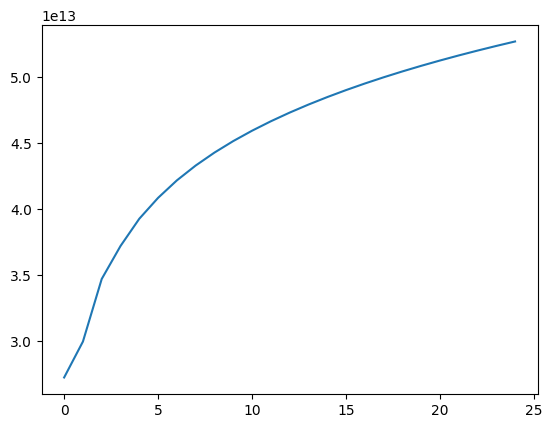

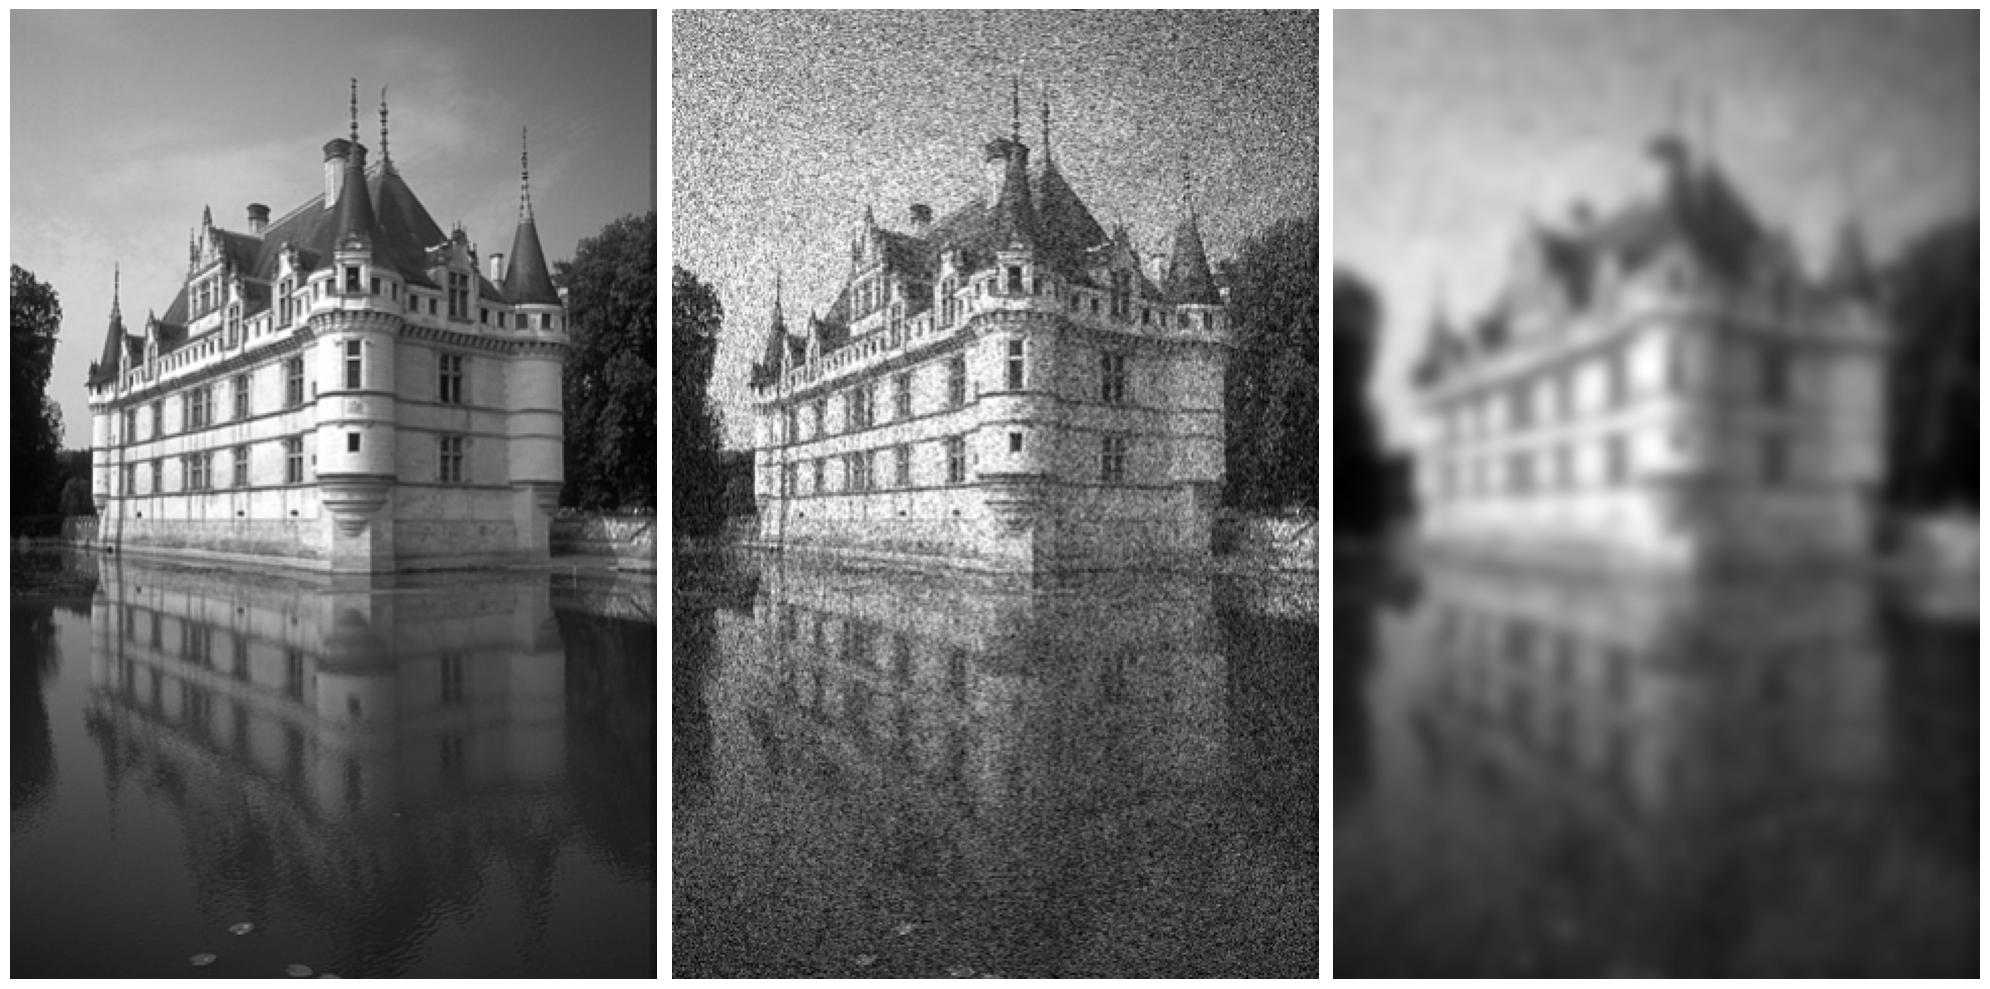

In [31]:
plt.plot(energy)
plt.show()
plot_images([clean_img_new, noisy_img_new, denoised_image_new], figsize=(20, 20))

# Нейросетвые Модели

In [32]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
import os
from PIL import Image

<b> Загрузка данных </b>

In [45]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.noisy_images = []
        self.clean_images = []
        
        # Loop over the images in the 'noise' and 'original' folders and store them
        for folder_name in ['input', 'gt']:
            folder_path = os.path.join(root_dir, folder_name)
            for img_name in os.listdir(folder_path):
                if img_name == '.DS_Store':
                    continue
                img_path = os.path.join(folder_path, img_name)
                if folder_name == 'input':
                    self.noisy_images.append(img_path)
                else:
                    self.clean_images.append(img_path)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        # Load the noisy and clean images at the specified index
        noisy_img_path = self.noisy_images[idx]
        clean_img_path = self.clean_images[idx]
        
        noisy_img = Image.open(noisy_img_path)
        clean_img = Image.open(clean_img_path)

        # Apply transformations, if any
        if self.transform:
            noisy_img = self.transform(noisy_img)
            clean_img = self.transform(clean_img)

        # Return the noisy and clean images as a tuple
        return noisy_img, clean_img

In [46]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

In [47]:
train_set = ImageDataset("./data/denoise/train/", transform=transform)
print(len(train_set))

68


In [48]:
test_set = ImageDataset("./data/denoise/test/", transform=transform)
print(len(test_set))

21


In [49]:
def plot_images_dataset(dataset, n_rows=3, n_cols=3):
    # Create a grid of n_rows x 2*n_cols subplots
    fig, axs = plt.subplots(n_rows, 2*n_cols, figsize=(10, 5))
    
    # Apply a transform to convert the tensor data to an image
    transform = transforms.ToPILImage()
    
    # Loop over the subplots and plot an image from the dataset
    for i in range(n_rows):
        for j in range(n_cols):
            # Get a random image and its noise from the dataset
            index = i * n_cols + j
            noise, img = dataset[index]
            
            # Convert the image tensors to images
            img = transform(img)
            noise = transform(noise)
            
            # Plot the images on the subplots
            axs[i, 2*j].imshow(img, cmap="gray")
            axs[i, 2*j].axis('off')
            axs[i, 2*j].set_title("Original")
            
            axs[i, 2*j+1].imshow(noise, cmap="gray")
            axs[i, 2*j+1].axis('off')
            axs[i, 2*j+1].set_title("Noise")
    
    # Show the plot
    plt.show()

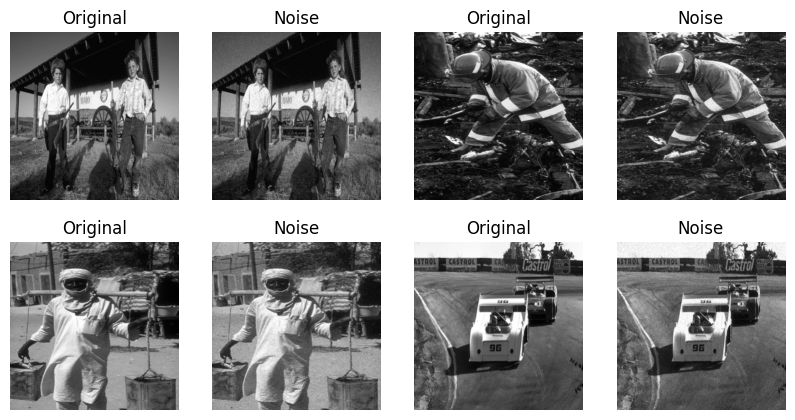

In [50]:
plot_images_dataset(train_set, 2, 2)

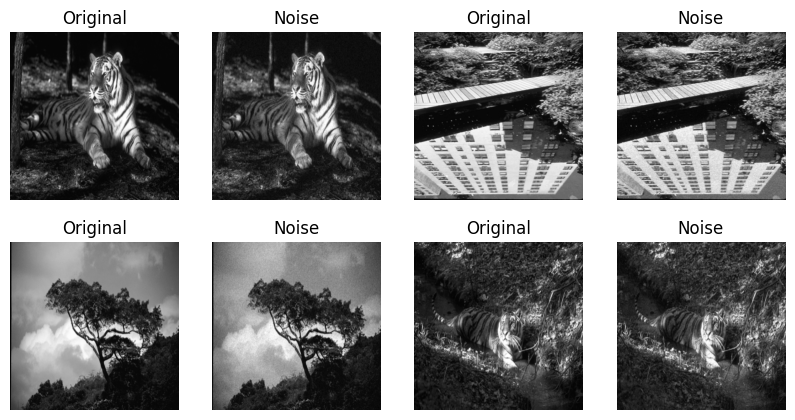

In [51]:
plot_images_dataset(test_set, 2, 2)

In [52]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

In [53]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

<b>Архитектура простой сети </b>

In [54]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.Sequential(
            nn.Conv2d(1,16,3,stride=2,padding=1), #[(inputsize+2*padding-filter_size)/stride] + 1
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,5),
            nn.ReLU()        
        )
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,5),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1), #(inputsize-1)*stride + kernal_size + output_padding - 2*padding
            nn.Sigmoid()

        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [55]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [56]:
model = Autoencoder().to(device)
loss_function = MultiScaleSSIMLoss().to(device) # DISTS, FLIP, 
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

Epoch : 1, loss : 0.622623563689344 
Epoch : 2, loss : 0.3975130608853172 
Epoch : 3, loss : 0.2543867808931014 
Epoch : 4, loss : 0.19426200495046728 
Epoch : 5, loss : 0.17013068672488718 
Epoch : 6, loss : 0.14922480109859915 
Epoch : 7, loss : 0.13127667413038366 
Epoch : 8, loss : 0.11898513576563667 
Epoch : 9, loss : 0.11123826398568995 
Epoch : 10, loss : 0.10847418974427615 


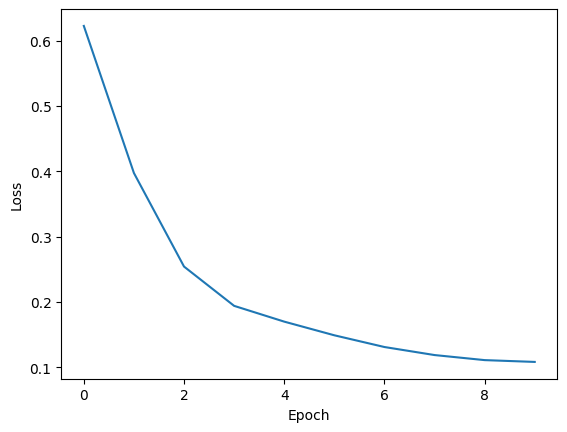

In [57]:
losses = []
l = len(train_set)
running_loss =0 

for epoch in range(10):
    for (noisy_img, target_img) in train_loader:
        noisy_img = noisy_img.to(device)
        target_img = target_img.to(device)
        
        reconstruction = model(noisy_img)
        loss = loss_function(reconstruction, target_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    losses.append(running_loss/l)
    print(f"Epoch : {epoch+1}, loss : {losses[epoch]} ")
    running_loss=0

plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(losses)

SSIM: 0.97, 0.66
PSNR: 84.95, 60.94


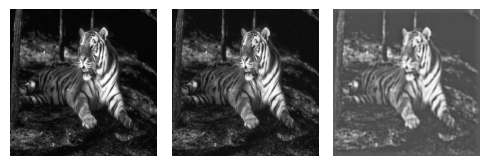

SSIM: 0.97, 0.66
PSNR: 82.33, 61.91


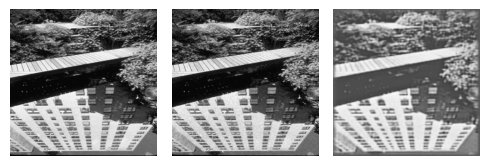

SSIM: 0.89, 0.73
PSNR: 82.60, 62.28


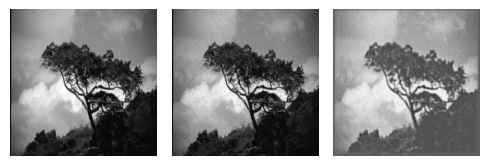

SSIM: 0.97, 0.67
PSNR: 84.26, 61.85


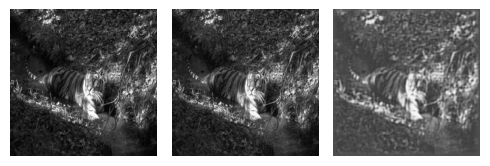

SSIM: 0.89, 0.78
PSNR: 83.17, 62.56


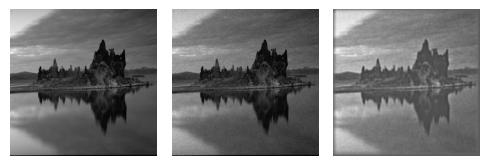

SSIM: 0.93, 0.73
PSNR: 82.44, 62.95


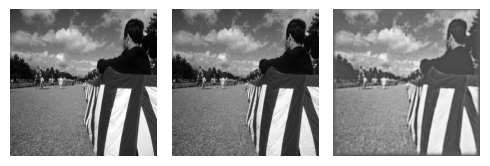

SSIM: 0.90, 0.81
PSNR: 82.41, 63.79


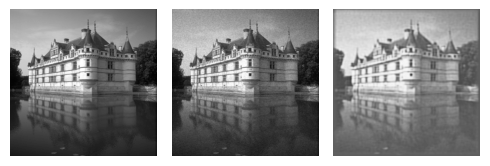

SSIM: 0.92, 0.63
PSNR: 84.37, 60.54


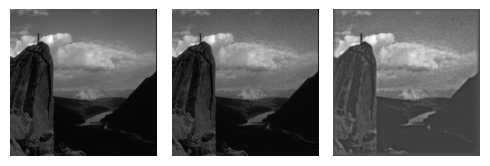

SSIM: 0.97, 0.77
PSNR: 82.69, 63.16


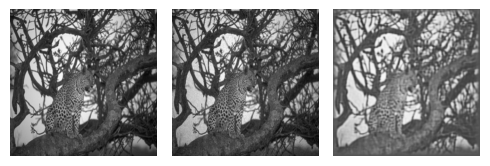

SSIM: 0.90, 0.84
PSNR: 80.91, 64.82


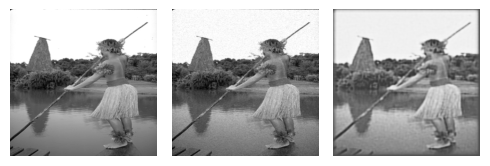

SSIM: 0.91, 0.79
PSNR: 83.29, 63.02


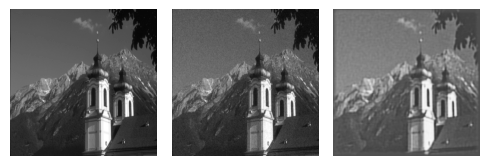

SSIM: 0.97, 0.67
PSNR: 82.88, 62.22


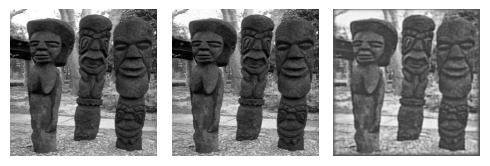

SSIM: 0.97, 0.69
PSNR: 83.26, 62.30


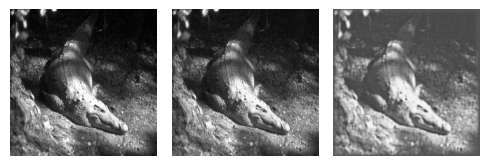

SSIM: 0.95, 0.69
PSNR: 82.69, 61.68


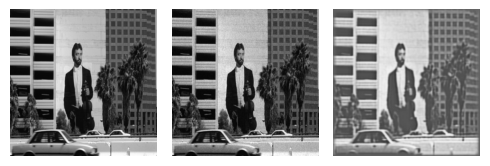

SSIM: 0.93, 0.79
PSNR: 80.34, 66.10


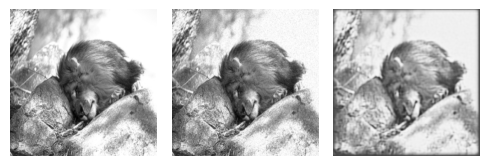

SSIM: 0.94, 0.81
PSNR: 83.23, 63.20


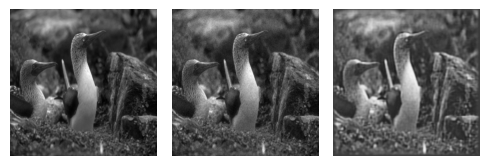

SSIM: 0.94, 0.82
PSNR: 82.99, 63.66


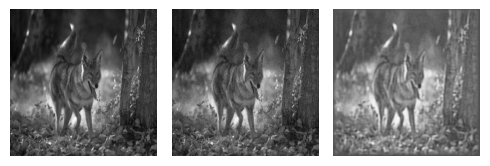

SSIM: 0.85, 0.87
PSNR: 80.86, 66.56


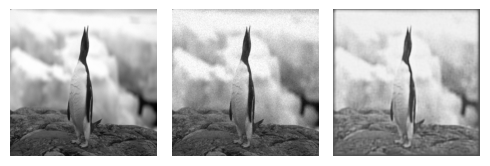

SSIM: 0.96, 0.77
PSNR: 83.09, 63.25


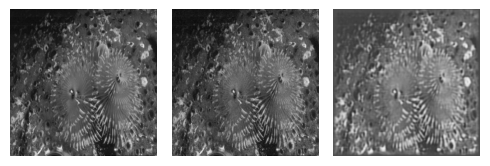

SSIM: 0.93, 0.83
PSNR: 82.05, 64.34


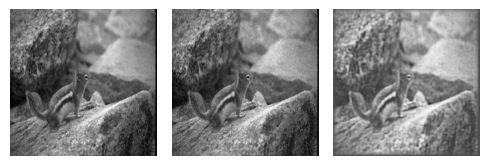

SSIM: 0.97, 0.74
PSNR: 83.87, 62.28


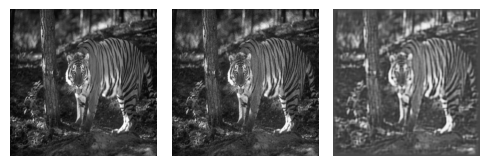

In [58]:
with torch.no_grad():
    for (noisy_img, target_img) in test_set:
        noisy_img_gpu = noisy_img.to(device)
        
        reconstruction = model(noisy_img_gpu).cpu()
        
        ssim_value = ssim(noisy_img[np.newaxis, ...], target_img[np.newaxis, ...])
        ssim_reconstructio = ssim(reconstruction[np.newaxis, ...], target_img[np.newaxis, ...])
        print(f"SSIM: {ssim_value:.2f}, {ssim_reconstructio:.2f}")
        
        psnr_value = psnr(noisy_img, target_img)
        psnr_reconstructio = psnr(reconstruction, target_img)
        print(f"PSNR: {psnr_value:.2f}, {psnr_reconstructio:.2f}")
        
        plot_images([target_img.squeeze(0), noisy_img.squeeze(0), reconstruction.cpu().numpy().squeeze(0)])